## Installation of SMAC and its Dependencies

In [1]:
!apt-get install swig -y
!pip install Cython
!pip install pyrfr==0.8.0 --no-cache --user
# hack to find pyrfr
import sys
sys.path.insert(0,"./.local/lib/python3.6/site-packages")

!pip install git+https://github.com/automl/SMAC3.git@development

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.10-1.2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
  Cloning https://github.com/automl/SMAC3.git (to revision development) to /tmp/pip-req-build-o5j6ersg
  Running setup.py bdist_wheel for smac ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-jnyxwarj/wheels/f4/8d/4f/2ba4cb80693f139ea06c2e8541e012a93738fb56bc1e43a202
Successfully built smac


## Forrester Function

In [0]:
import math
import numpy as np

def forrester_func(x):
    # x is vector contains 1 value.
    x = x[0]
    first = (6*x - 2)**2
    second = np.sin(12*x - 4)
    return first * second

##Loss Function

In [0]:
def loss(x):
  fx = forrester_func(x)
  # The minimum value of the function.
  fx_star = -6.02074
  return np.log(fx - fx_star)

## Plot Function

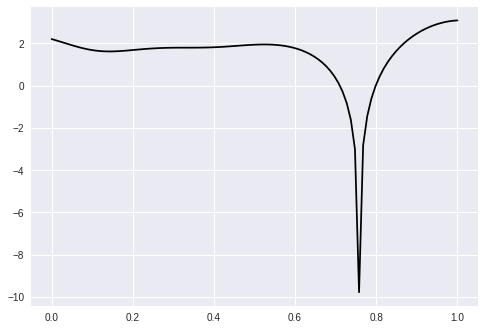

In [4]:
x_points = np.linspace(start=0,stop=1,num=100) 
y_points = list(map(loss,map(lambda x: [x], x_points)))

import matplotlib.pyplot as plt
plt.plot(x_points, y_points, 'k')


## Optimize with SMAC

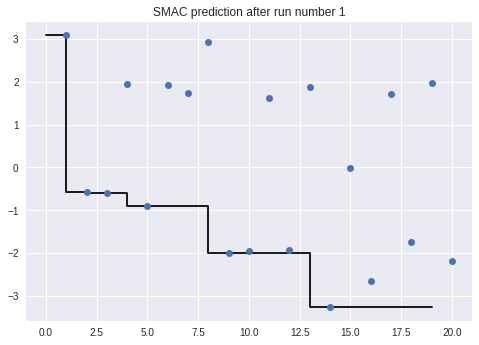

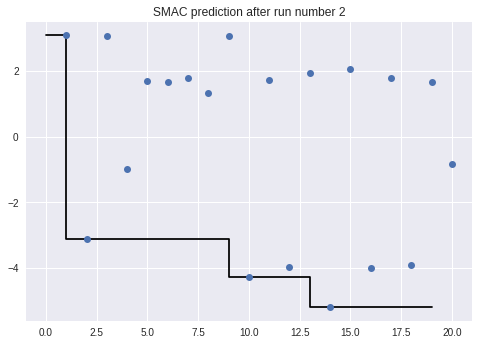

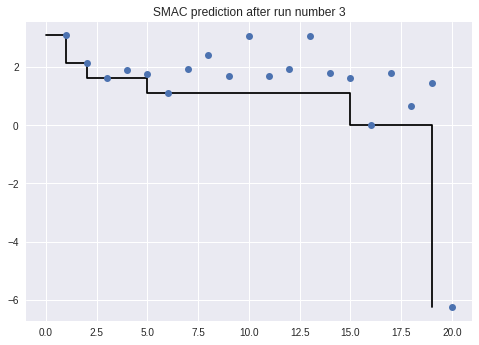

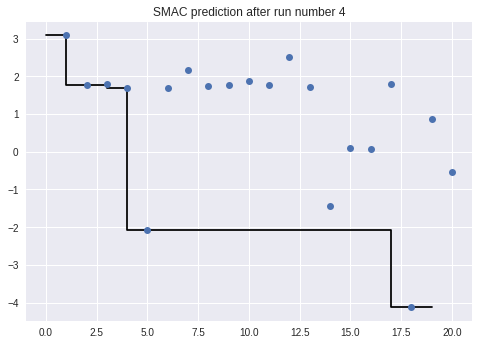

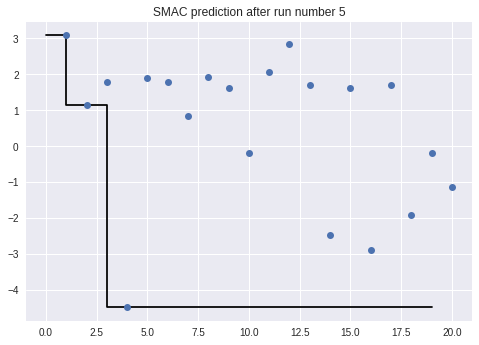

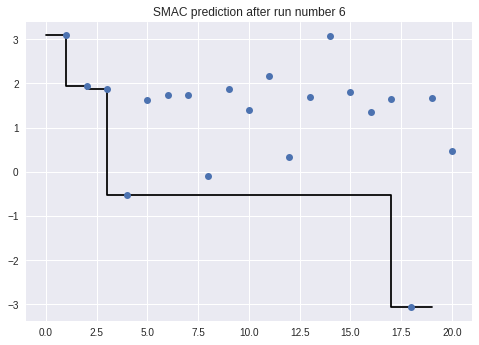

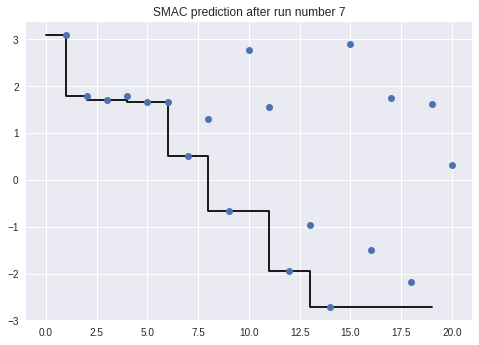

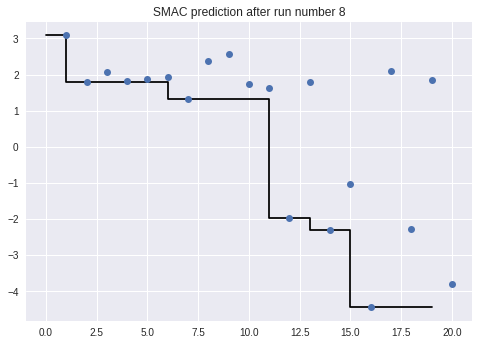

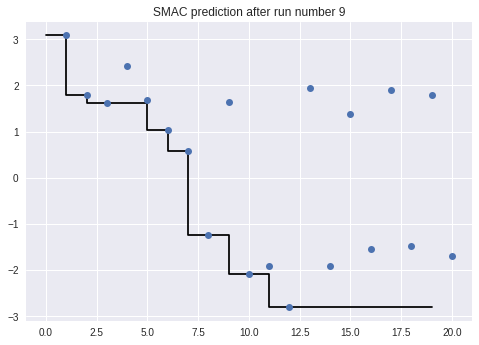

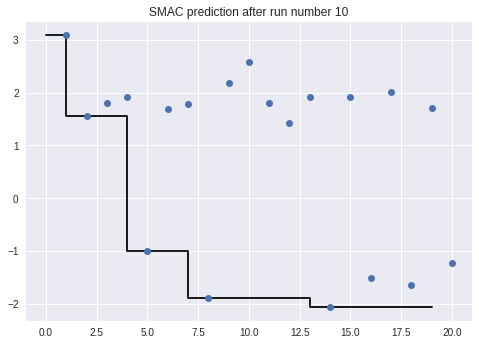

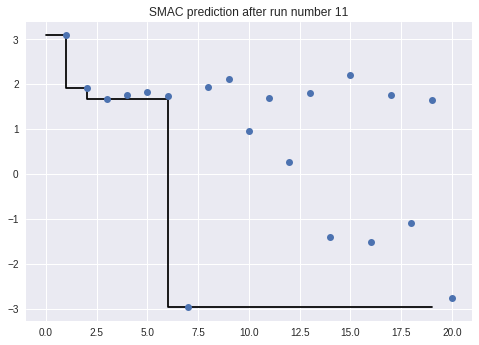

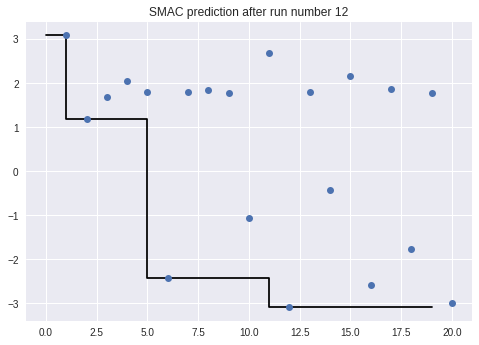

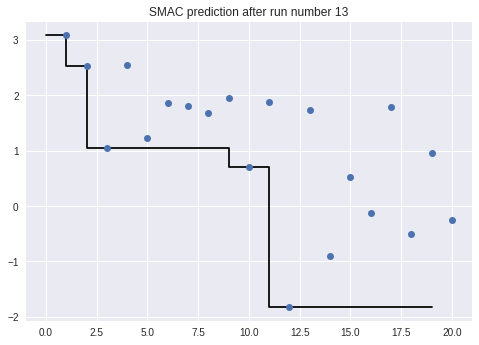

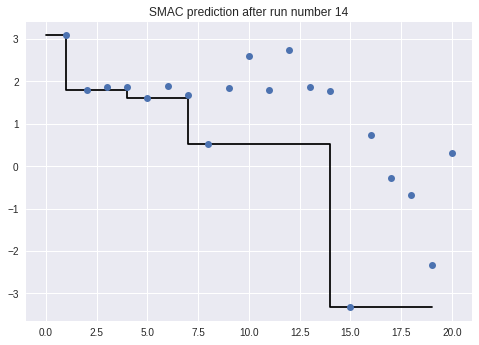

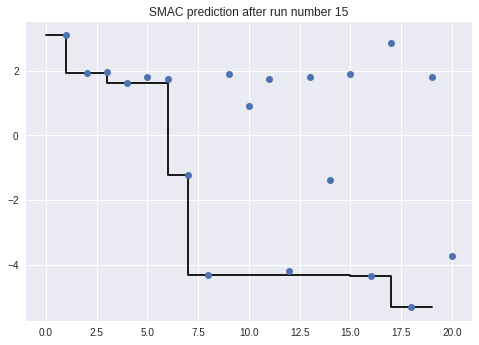

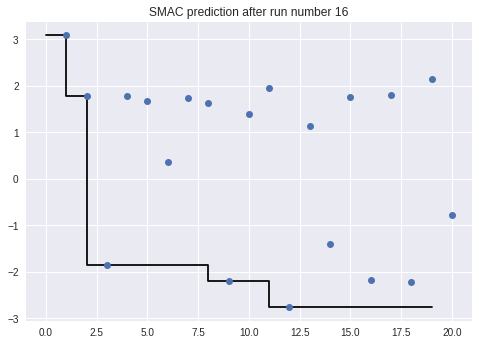

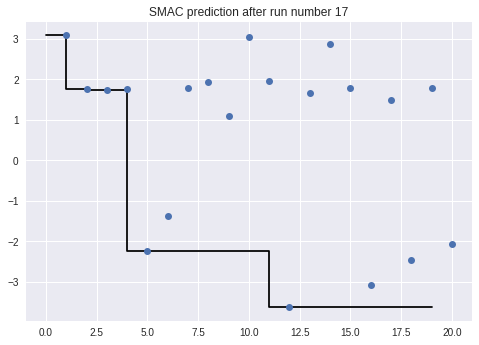

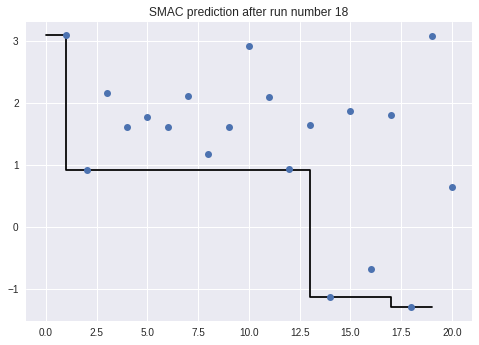

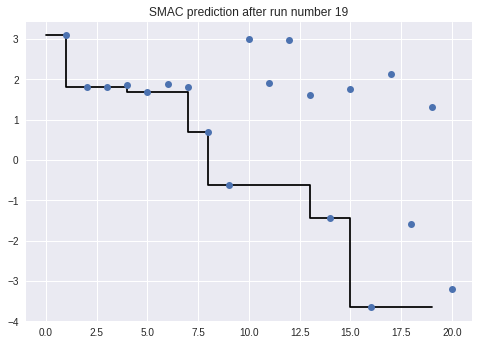

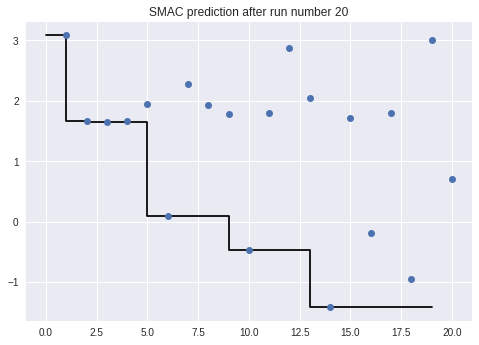

In [6]:
import numpy as np
from smac.facade.func_facade import fmin_smac

MAX_FUN = 20
full_data = [] # 2d Matrix for function evalution and 20 runs
for index in range(20):
  # Random Seed to make plot different.
  seed = np.random.randint(1111,2222)
  x, cost, smac = fmin_smac(func=loss,
                         x0=[1], # default values
                         bounds=[(0, 1)], # bounds of each x
                         maxfun=MAX_FUN, # maximal number of function evaluations 
                         rng=seed # random seed
                         )
  runhistory = smac.get_runhistory()
  y_smac = []
  for entry in runhistory.data: 
    config_id = entry.config_id
    config = runhistory.ids_config[config_id] 
    y_ = runhistory.get_cost(config) 
    y_smac.append(y_)
  
  full_data.append(y_smac)
  y_smac = np.array(y_smac)
  
  loss_value = []
  x_loss = []
  min_loss = 1e9
  x_loss.extend(range(1, MAX_FUN + 1))
  # Assure that the step function is strictly decreasing.
  for idx in range(MAX_FUN):
    min_loss = min(min_loss, y_smac[idx])
    loss_value.append(min_loss)
    
  # Plot the step function and the function evaluations.
  fig1 = plt.figure()
  ax1 = fig1.add_subplot(111)
  ax1.step(loss_value, 'k', where="post")
  ax1.plot(x_loss, y_smac, 'o')
  plt.title("SMAC prediction after run number %i"% (index + 1))
  plt.show()


## How has SMAC performed over time?

Text(0.5,1,'SMAC Performance')

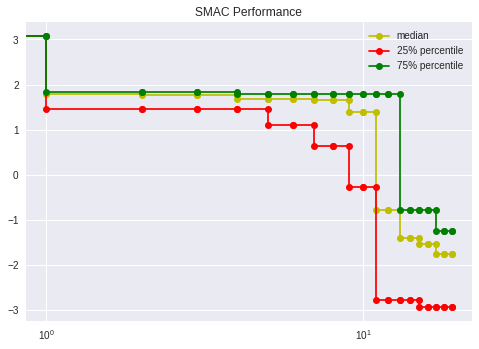

In [7]:
full_data = np.array(full_data)
# Transpose the matrix to get the 20 runs of each evaluation.
full_data = np.transpose(full_data)
# Median, 25% and 75 percentiles.
med, quart, triquart = [], [], []

for index in range(MAX_FUN):
  single_run = full_data[index]
  single_run = np.sort(single_run)
  med.append(np.percentile(single_run, 50))
  quart.append(np.percentile(single_run, 25))
  triquart.append(np.percentile(single_run, 75))
  
min_med, min_quart, min_tri = 1e9, 1e9, 1e9
# Assure that each step function is decreasing.
for idx in range(MAX_FUN):
  min_med = med[idx] = min(med[idx], min_med)
  min_quart = quart[idx] = min(quart[idx], min_quart)
  min_tri = triquart[idx] = min(triquart[idx], min_tri)
# Plotting the 3 function side by side.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.step(med, 'yo', where='post', label='median')
ax.step(quart, 'ro', where='post', label='25% percentile')
ax.step(triquart, 'go', where='post', label = '75% percentile')
ax.legend(loc = 'upper right')
ax.set_xscale('log')
plt.title('SMAC Performance')

## Random Search : ROAR

In [9]:
from smac.facade.roar_facade import ROAR
from smac.scenario.scenario import Scenario
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter


cs = ConfigurationSpace()

# Declaring Variables in configuration space. 
x_points = UniformFloatHyperparameter("x", 0, 1, default_value=1)


cs.add_hyperparameters([x_points])
scenario = Scenario({"run_obj": "quality",   # we optimize quality (alternative runtime)
                      "wallclock_limit": 5, # time for running SMAC
                     "deterministic": "true",
                     "cs": cs,
                     "memory_limit": 3072,   # adapt this to reasonable value for your hardware
                     "output_dir": ""        # deactivate output
                    })
def cfg(cfg, seed):
    return  loss([cfg["x"]])

roar_data = []

# Putting ROAR values in 2d matrix like SMAC.
for index in range(20):
  y_roar = []
  seed = np.random.randint(1111,2222)
  roar = ROAR(scenario=scenario, rng=np.random.RandomState(seed),
              tae_runner=cfg)
  incumbent = roar.optimize()
  history = roar.get_runhistory()
  for entry in history.data: 
    config_id = entry.config_id
    config = history.ids_config[config_id] 
    y_ = history.get_cost(config) 
    y_roar.append(y_)
  
  y_roar = y_roar[:MAX_FUN]
  y_roar = np.array(y_roar)
  roar_data.append(y_roar)


roar_data = np.array(roar_data)
roar_data = np.transpose(roar_data)

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Plot ROAR

Text(0.5,1,'ROAR vs SMAC')

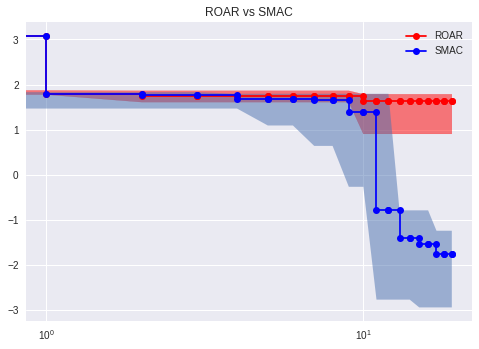

In [10]:
# Calculating ROAR percentiles and Plotting them beside SMAC.
rmed, rquart, rtriquart = [], [], []

for index in range(MAX_FUN):
  single_run = roar_data[index]
  single_run = np.sort(single_run)
  rmed.append(np.percentile(single_run, 50))
  rquart.append(np.percentile(single_run, 25))
  rtriquart.append(np.percentile(single_run, 75))
  
min_rmed, min_rquart, min_rtri = 1e9, 1e9, 1e9
for idx in range(MAX_FUN):
  min_rmed = rmed[idx] = min(rmed[idx], min_rmed)
  min_rquart = rquart[idx] = min(rquart[idx], min_rquart)
  min_rtri = rtriquart[idx] = min(rtriquart[idx], min_rtri)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.step(rmed, 'ro', where='post', label='ROAR')
ax.fill_between (range(MAX_FUN), rquart, rtriquart, alpha=0.5, color='r')
ax.step(med, 'bo', where='post', label='SMAC')
ax.fill_between (range(MAX_FUN), quart, triquart, alpha=0.5)
ax.legend(loc = 'upper right')
ax.set_xscale('log')
plt.title('ROAR vs SMAC')
  